In [150]:
# Step 1: Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score



In [151]:
data = pd.read_csv('renttherunway.csv')
if data is None or data.empty:
    raise ValueError("DataFrame is empty or not loaded correctly. Please check the CSV file path.")


In [152]:
print("Number of duplicates before dropping:", data.duplicated().sum())
data.drop_duplicates(inplace=True)
print("Number of duplicates after dropping:", data.duplicated().sum())


Number of duplicates before dropping: 0
Number of duplicates after dropping: 0


In [153]:
data.drop(columns=['user_id', 'item_id', 'review_text', 'review_date'], inplace=True)
data['weight'] = data['weight'].str.replace('lbs', '').astype(float)

In [154]:
def convert_height_to_inches(height_str):
    if isinstance(height_str, str):
        feet, inches = height_str.split("'")
        feet = int(feet.strip())
        inches = int(inches.strip().replace('"', ''))
        return feet * 12 + inches
    return height_str 
data['height'] = data['height'].apply(convert_height_to_inches)

In [155]:
print("Missing values in each column:\n", data.isnull().sum())

Missing values in each column:
 Unnamed: 0            0
fit                   0
bust size         18411
weight            29982
rating               82
rented for           10
body type         14637
review_summary      345
category              0
height              677
size                  0
age                 960
dtype: int64


In [156]:
numeric_cols = data.select_dtypes(include=[np.number]).columns
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())


In [157]:
print(data.describe())

          Unnamed: 0         weight         rating         height  \
count  192544.000000  192544.000000  192544.000000  192544.000000   
mean    96271.500000     137.391709       9.092371      65.310621   
std     55582.809453      20.122771       1.429740       2.658793   
min         0.000000      50.000000       2.000000      54.000000   
25%     48135.750000     125.000000       8.000000      63.000000   
50%     96271.500000     137.391709      10.000000      65.000000   
75%    144407.250000     145.000000      10.000000      67.000000   
max    192543.000000     300.000000      10.000000      78.000000   

                size            age  
count  192544.000000  192544.000000  
mean       12.245175      33.871017  
std         8.494877       8.037969  
min         0.000000       0.000000  
25%         8.000000      29.000000  
50%        12.000000      32.000000  
75%        16.000000      37.000000  
max        58.000000     117.000000  


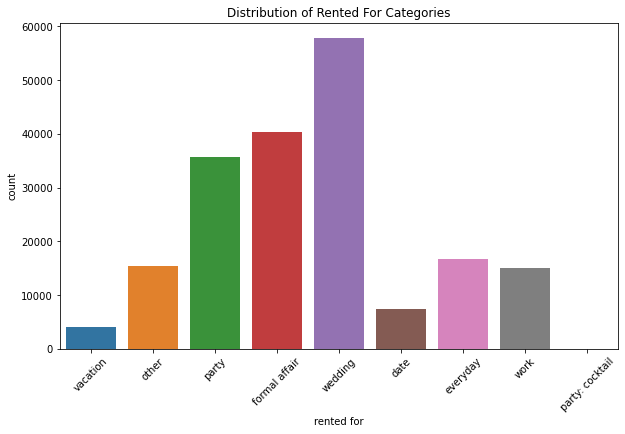

In [158]:
plt.figure(figsize=(10, 6))
sns.countplot(x='rented for', data=data)
plt.title('Distribution of Rented For Categories')
plt.xticks(rotation=45)
plt.show()

In [175]:
sample_size = 10000  # Adjust this size based on your memory capacity
data_sampled = data.sample(n=sample_size, random_state=42)
print("Non-numeric columns before encoding:", data.select_dtypes(exclude=[np.number]).columns)


Non-numeric columns before encoding: Index(['fit', 'bust size', 'rented for', 'body type', 'review_summary',
       'category'],
      dtype='object')


In [176]:
non_numeric_cols = ['fit', 'bust size', 'rented for', 'body type', 'review_summary', 'category']
data_sampled = pd.get_dummies(data_sampled, columns=non_numeric_cols, drop_first=True)


In [177]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_sampled.select_dtypes(include=[np.number]))


In [178]:
pca = PCA(n_components=0.95)
data_pca = pca.fit_transform(data_scaled)


In [181]:
inertia = []
silhouette_scores = []
K_range = range(2, 10)

In [182]:
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_pca)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(data_pca, kmeans.labels_))


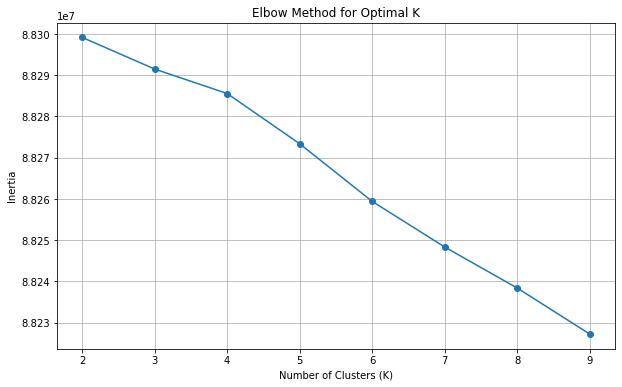

In [183]:
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.grid()
plt.show()


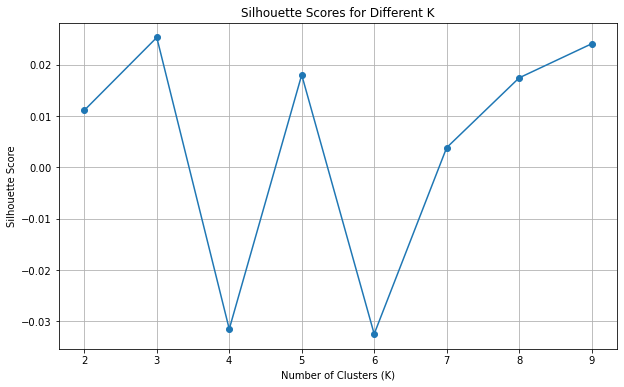

In [184]:
plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different K')
plt.grid()
plt.show()

In [ ]:
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_pca)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(data_pca, kmeans.labels_))


In [191]:
optimal_k = 4 
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data_sampled['cluster'] = kmeans.fit_predict(data_pca)
data['cluster'] = np.nan  
data.loc[data_sampled.index, 'cluster'] = data_sampled['cluster']

ValueError: Length of values (10000) does not match length of index (192544)

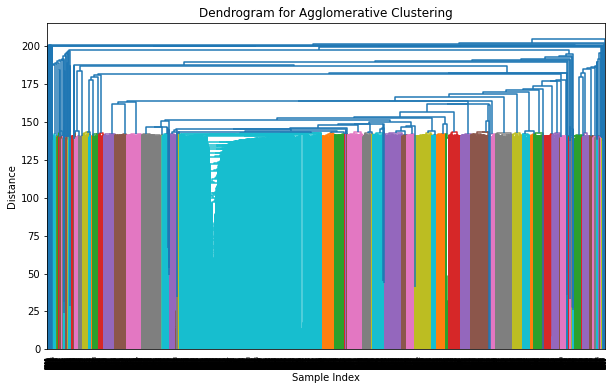

In [187]:
from scipy.cluster.hierarchy import dendrogram, linkage

plt.figure(figsize=(10, 6))
linked = linkage(data_pca, 'ward')
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrogram for Agglomerative Clustering')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()


In [188]:

optimal_k_agglomerative = 3
agglo = AgglomerativeClustering(n_clusters=optimal_k_agglomerative)
data['agglo_cluster'] = agglo.fit_predict(data_pca)


ValueError: Length of values (10000) does not match length of index (192544)

In [189]:
for i in range(optimal_k):
    print(f"Cluster {i} characteristics:")
    print(data[data['cluster'] == i].describe())
    print("\n")


Cluster 0 characteristics:


KeyError: 'cluster'

In [190]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=data['cluster'], palette='viridis')
plt.title('PCA of Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

KeyError: 'cluster'

<Figure size 720x432 with 0 Axes>